In [1]:
import sys
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.distributed as dist
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torch.multiprocessing as mp
import time
from requests import get
import os
import random
import math
import pickle
import argparse
import wandb
import gc

In [2]:
def GenerateDataset_pp(ndig, nextra):

    stoi = {'0': 0, '1': 1, '2': 2,'3': 3,'4': 4,'5': 5,'6': 6,'7': 7,'8': 8,'9': 9,'+': 10,'=': 11, 'x': 12}

    data = []
    target = []
    data_f = []
    target_f = []

    k = 0
    while k < 200000:
        i = int(10**(ndig*torch.rand(size=(1,)).item()))
        j = int(10**(ndig*torch.rand(size=(1,)).item()))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i+j}')
        if len(li) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(li), size=(1,))
            r1 = ndig+nextra - len(li) - r0
            li = ['x'] * r0 + li + ['x'] * r1
        if len(lj) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(lj), size=(1,))
            r1 = ndig+nextra - len(lj) - r0
            lj = ['x'] * r0 + lj + ['x'] * r1
        if len(lij) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(lij), size=(1,))
            r1 = ndig+nextra - len(lij) - r0
            if r1 > 0:
                lij = ['x'] * r0 + lij + ['='] + ['x'] * (r1 - 1)
            else:
                lij = ['x'] * r0 + lij

        lsum = li + ['+'] + lj + lij

        if lsum[-1] in ['=', 'x']:
            lt = lsum[1:] + ['x']
        else:
            lt = lsum[1:] + ['=']
        data.append([stoi[lsum[i]] for i in range(len(lsum))])
        target.append([stoi[lt[i]] for i in range(len(lt))])

        include = False
        while not include:
            i = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            j = int(10**(ndig+(nextra)*torch.rand(size=(1,)).item()))
            include = (i + j < 10**(ndig+nextra))

        li = list(f'{i}')
        lj = list(f'{j}')
        lij = list(f'{i+j}')
        if len(li) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(li), size=(1,))
            r1 = ndig+nextra - len(li) - r0
            li = ['x'] * r0 + li + ['x'] * r1
        if len(lj) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(lj), size=(1,))
            r1 = ndig+nextra - len(lj) - r0
            lj = ['x'] * r0 + lj + ['x'] * r1
        if len(lij) < ndig+nextra:
            r0 = torch.randint(0, ndig+nextra - len(lij), size=(1,))
            r1 = ndig+nextra - len(lij) - r0
            if r1 > 0:
                lij = ['x'] * r0 + lij + ['='] + ['x'] * (r1 - 1)
            else:
                lij = ['x'] * r0 + lij

        lsum = li + ['+'] + lj + lij

        if lsum[-1] in ['=', 'x']:
            lt = lsum[1:] + ['x']
        else:
            lt = lsum[1:] + ['=']

        data_f.append([stoi[lsum[i]] for i in range(len(lsum))])
        target_f.append([stoi[lt[i]] for i in range(len(lt))])
        k += 1

    data_f = torch.LongTensor(data_f)
    target_f = torch.LongTensor(target_f)
    data = torch.LongTensor(data)
    target = torch.LongTensor(target)

    vocab = len(stoi)
    
    return vocab, data, target, data_f, target_f


In [4]:
class DecoderTot(nn.Module):

  def __init__(self, decoder, embed, generator):
    super().__init__()
    self.embed = embed
    self.gen = generator
    self.decoder = decoder
    self.generator = generator

  def forward(self, src, mask):
    return self.generator(self.decoder(self.embed(src), mask))


class Generator(nn.Module):

  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.ln = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    return F.log_softmax(self.ln(x), dim=-1)

class Decoder(nn.Module):

    def __init__(self, attn, ffn, d_model, dropout):
        super().__init__()
        self.attn = attn
        self.ffn = ffn
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.out = None

    def forward(self, x, mask):

        x1 = self.norm(x)
        x = x + self.dropout(self.attn(x1, x1, x1, mask))
        self.out = x + self.dropout(self.ffn(self.norm(x)))
        return self.out

class DecoderStack(nn.Module):

    def __init__(self, layer, N):
        super().__init__()
        self.N = N
        self.norm = nn.LayerNorm(layer.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

def Attention(q, k, v, theta, mask=None, dropout=None):

            ### -- Softmax Attention with RoFormer -- ###

            # q, k, v are dims (batch_size, # heads, seq_len, d_{k,v})

            m = torch.arange(k.shape[-2]).view(k.shape[-2], 1).to(q.device)
            t = torch.arange(k.shape[-1]).view(1, k.shape[-1])
            t = torch.exp( - ( 2 * np.log(theta) / k.shape[-1] ) * torch.floor(t/2.) ).to(q.device)
            r1 = torch.cos(m * t)
            r2 = torch.sin(m * t)

            K = torch.cat((q, k, v))

            Kp = torch.einsum('ijkl, kl -> ijkl', K, r1)

            L = torch.kron(torch.eye(k.shape[-1]//2), torch.Tensor([[0,-1],[1,0]])).to(q.device)
            K = torch.einsum('ijkl, ml -> ijkm', K, L)

            Kp += torch.einsum('ijkl, kl -> ijkl', K, r2)

            Kp = Kp.view(-1, k.shape[0], k.shape[1], k.shape[2], k.shape[-1])

            q, k, v = Kp[0], Kp[1], v # Kp[2]

            A = torch.matmul(q, k.transpose(-2,-1)) * k.size(-1)**(-0.5)

            if mask is not None:
                A.masked_fill_(mask == 0, float('-inf'))

            O = F.softmax(A, dim=-1)

            if dropout is not None:
                O = dropout(O)

            return torch.matmul(O, v), O


class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        self.d_k = d_model // h
        self.h = h
        self.attn = None
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.dropout =  nn.Dropout(p=dropout)
        self.theta = 1000.0

    def forward(self, query, keys, values, mask=None):

        batch_size = query.shape[0]

        x = [l(z).view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for l, z in zip(self.linears, (query, keys, values))]

        y, self.attn = Attention(x[0], x[1], x[2], self.theta, mask=mask, dropout=self.dropout)

        y = y.transpose(1,2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.linears[-1](y)

class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.out = None
        self.out_p = None

    def forward(self, x):
        self.out = self.relu(self.w1(x))
        self.out_p = self.w2(self.dropout(self.out))
        return self.w2(self.dropout(self.out))

class Embeddings(nn.Module):

    def __init__(self, src_vocab, d_model):
        super().__init__()
        self.Emb = nn.Embedding(src_vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.Emb(x) * np.sqrt(self.d_model)

def make_model(vocab, N = 6, d_model = 512, d_ff = 2048, h = 8, dropout = 0.1):

    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ffn = FeedForward(d_model, d_ff, dropout)

    model = DecoderTot(DecoderStack(Decoder( c(attn), c(ffn), d_model, dropout), N),
                           Embeddings(vocab, d_model),  Generator(d_model, vocab))

    for p in model.parameters():
        if p.dim() > 1: # This is there to not initialize the biases
            nn.init.xavier_uniform_(p)
    # print('# of parameters =', sum(p.nelement() for p in model.parameters())) # number of parameters in total

    return model

class Dataset(torch.utils.data.Dataset):

    def __init__(self, inputs, target):
        self.inputs = inputs
        self.target = target

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        src = self.inputs[index]
        tgt = self.target[index]

        return src, tgt

def prepare(rank, world_size, data, target, batch_size, pin_memory=True, num_workers=0):

    dataset = Dataset(data, target)
    # sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False, drop_last=False)

    # dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False, sampler=sampler)
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False)
    return dataloader

def cleanup():
    dist.destroy_process_group()

def accuracy_calc(inputs, targets, max_gen, ignore_idx):
    acc = []
    for i in range(inputs.shape[0]):
        in_z = inputs[i, -max_gen:][inputs[i, -max_gen:] != ignore_idx]
        target_z = targets[i, -max_gen:][targets[i, -max_gen:] != ignore_idx]
        try:
            acc_z = (in_z == target_z).float().min().item()

            acc.append(acc_z)
        except:
            continue
    
    if len(acc) == 0:
        return 'zero', 0.0
    
    return 'non-zero', sum(acc) / len(acc)

def run_epoch(data, loader, model, optimizer, device, status='train'):

    for i, batch in enumerate(loader):

        src, tgt = batch[0].to(device), batch[1].to(device)
        
        ignore_idx = 12

        seq_len = src.shape[-1]
        num_digits = (seq_len - 1) // 3
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(device)
        logits = model.forward(src, mask)[:, -(num_digits + 1):]
        tgt = tgt[:, -(num_digits + 1):]

        kl_loss = nn.CrossEntropyLoss(ignore_index=ignore_idx)

        loss = kl_loss(logits.transpose(-1, -2), tgt) # We want inputs to be (bs, vocab_size, seq len), so needed a transpose. Targets are (bs, seq len) with values in [0, vocab_size]

        l = loss.detach().item()

        if status == 'train':
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            pre_data = torch.tensor(l) # correctness, loss
            if i % 200 == 0:
                print(f'---{status} loss ---')
                print(l)

        if status == 'eval':
            # s, a = accuracy_calc(torch.argmax(logits.detach(), dim=-1), tgt, num_digits + 1, ignore_idx=ignore_idx)
            w2 = sum((p.data**2).sum() for p in model.parameters()).clone().detach().to('cpu')
            pre_data = torch.tensor([l, w2.item()])

            if i % 200 == 0:
                print(f'---{status} loss ---')
                print(l)
                # print(s, a)
        
        data = torch.cat((data, pre_data.unsqueeze(0)), 0)

        del loss, tgt, src, logits
        gc.collect

    return data

def train(args):

    ### Dataset

    print('--- Generating data ---')
    vocab, data, target, data_f, target_f = GenerateDataset_pp(ndig=args.ndigits, nextra = args.nextra)
    print('--- Finished generating data ---')
    # Three way split (training, test)
    random.seed()
    z = list(zip(data.tolist(), target.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_array_sh, tgt_array_sh = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    rank = torch.device('cuda:0')
    world_size = 0

    # Dataset parameters

    batch_size = args.batch_size
    batch_size_eval = args.batch_size_eval

    vocab = vocab

    split = args.split

    n1 = int(split*len(src_array_sh))
    n2 = 2*n1
    # n1 = 0
    # n0 = 100
    priming_examples = 0

    src_train, src_test = src_array_sh[:n1], src_array_sh[n1:n2]
    tgt_train, tgt_test = tgt_array_sh[:n1], tgt_array_sh[n1:n2]
    src_long, tgt_long = data_f[:priming_examples], target_f[:priming_examples]
    src_test_long, tgt_test_long = data_f[priming_examples:], target_f[priming_examples:]

    # src_train = torch.cat((src_train, src_long), 0)
    # tgt_train = torch.cat((tgt_train, tgt_long), 0)
    # src_train = src_long
    # tgt_train = tgt_long

    random.seed()
    z = list(zip(src_train.tolist(), tgt_train.tolist()))
    random.shuffle(z)

    z1, z2 = zip(*z)
    src_train, tgt_train = torch.LongTensor(list(z1)), torch.LongTensor(list(z2))

    dataloader_train = prepare(rank, world_size, src_train, tgt_train, batch_size)

    dataloader_test = prepare(rank, world_size, src_test, tgt_test, batch_size_eval)

    dataloader_test_long = prepare(rank, world_size, src_test_long, tgt_test_long, batch_size_eval)

    ### Model

    d_model = args.d_model
    d_ff = args.d_ff
    n_heads = args.heads
    n_layers = args.num_layers

    # model = make_model(d_model=d_model,
    #                    n_heads=n_heads,
    #                    d_ff=d_ff,
    #                    vocab=vocab,
    #                    N=n_layers
    #                    )

    model = make_model(vocab, N = n_layers, d_model = d_model, d_ff = d_ff, h = n_heads, dropout = 0.1)

    model = model.to(rank)

    ### Training parameters and optimizer

    lr = args.learning_rate
    weight_decay = args.weight_decay    
    num_epochs = args.epochs

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr = lr,
                                  betas = (0.9, 0.98),
                                  eps=1e-8,
                                  weight_decay=weight_decay)

    ### Tracking

    theta = model.decoder.layers[0].attn.theta

    wandb.init(project="Generative Addition",
                     config={"lr": lr,
                             "split":split,
                             "layers": n_layers,
                             "weight decay": weight_decay,
                             "d_ff": d_ff,
                             "d_model": d_model,
                             "heads": n_heads,
                             "theta": theta,
                             "Priming examples": priming_examples,
                             "n digits train": args.ndigits,
                             "n digits test": f'{args.ndigits} + {args.nextra}',
                             "batch size": batch_size,
                             "batch_size_eval": batch_size_eval,
                             'random padding': True,
                             'ID': args.ID,
                             }
                        )

    ### Training    

    for epoch in range(num_epochs):
        print(f' --- {epoch} ---')
        data = torch.tensor([])
        data_t = torch.tensor([])
        data_tl = torch.tensor([])

        model.train()
        data = run_epoch(data, loader=dataloader_train, model=model, optimizer=optimizer, device=rank, status='train')
        
        data = data.mean(dim=0)
        s = {}
        s['training loss'] = data
        # s['training acc.'] = data[-2]
        wandb.log(s,
            step=epoch
            )

        model.eval()
        with torch.no_grad():
            data_t = run_epoch(data_t, loader=dataloader_test, model=model, optimizer=optimizer, device=rank, status='eval')

            data_tl = run_epoch(data_tl, loader=dataloader_test_long, model=model, optimizer=optimizer, device=rank, status='eval')

        data = data_t.mean(dim=0)
        data_long = data_tl.mean(dim=0)

        s = {}
        s['test loss'] = data[-2]
        # s['test acc.'] = data[-3]
        s['norm weights squared'] = data[-1]

        s['test loss long'] = data_long[-2]
        # s['test acc. long'] = data_long[-3]
        wandb.log(s,
            step=epoch
            )

        if epoch % 50 == 0:
            outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_epoch{!s}'.format(n_layers, split, weight_decay, epoch)

            torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, outputFile)

    # cleanup()
    wandb.finish()

    outputFile = args.output_dir + '/model_n{!s}_s{!s}_w{!s}_{!s}_final'.format(n_layers, split, weight_decay, args.ID)

    torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
            }, outputFile)
    return model

In [13]:
parser = argparse.ArgumentParser()

parser.add_argument("--split", default=0.3, type=float)
parser.add_argument("--weight_decay", default=0.3, type=float)
parser.add_argument("--num_layers", default=6, type=int)
parser.add_argument("--d_model", default=512, type=int)
parser.add_argument("--d_ff", default=2048, type=int)
parser.add_argument("--heads", default=8, type=int)
parser.add_argument("--epochs", default=10, type=int)
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--batch_size_eval", default=1024, type=int)
parser.add_argument("--learning_rate", default=1e-3, type=float)
parser.add_argument("--ndigits", default=5, type=int)
parser.add_argument("--nextra", default=15, type=int)
parser.add_argument("--output_dir", default="generative/", type=str)
parser.add_argument("--ID", default=16, type=int)

args = parser.parse_args(args=[])

model = train(args)

--- Generating data ---
--- Finished generating data ---


training loss,▁
training loss,1.97286


 --- 0 ---
---train loss ---
3.129304885864258
---train loss ---
2.087799549102783
---train loss ---
2.005053758621216
---train loss ---
1.8962360620498657
---train loss ---
2.0656561851501465
---train loss ---
1.9396512508392334
---train loss ---
2.0247485637664795
---train loss ---
1.8661630153656006
---train loss ---
1.8286575078964233
---train loss ---
1.9586646556854248
---eval loss ---
1.8151261806488037
---eval loss ---
4.8677144050598145
 --- 1 ---
---train loss ---
1.7702956199645996
---train loss ---
1.7478282451629639
---train loss ---
1.6920605897903442
---train loss ---
1.6502399444580078
---train loss ---
1.5660897493362427
---train loss ---
1.482843279838562
---train loss ---
1.6153030395507812
---train loss ---
1.553171992301941
---train loss ---
1.3898195028305054
---train loss ---
1.313326120376587
---eval loss ---
1.2403157949447632
---eval loss ---
3.1966092586517334
 --- 2 ---
---train loss ---
1.1400535106658936
---train loss ---
1.124019980430603
---train loss --

norm weights squared,▄█▅▄▄▄▃▂▂▁
test loss,█▆▂▂▁▁▁▁▁▁
test loss long,▄▁▃▄▆█▄▅▄▃
training loss,█▆▃▂▁▁▁▁▁▁
norm weights squared,17812.95117
test loss,0.06109
test loss long,4.11234
training loss,0.13046


In [3]:
vocab, data, target, data_f, target_f = GenerateDataset_pp(5, 15)

In [22]:
output_file = 'generative/model_n6_s0.3_w0.3_15_final'
n_layer = 6 # number of layers
d_model = 512 # model dimension, residual stream
d_ff = 2048 # dim intermediate feed-forward layer
h_a = 8 # number of heads in attention (doesnt impact # of params)

model = make_model(vocab=13, N = n_layer, d_model = d_model, d_ff = d_ff, h = h_a)

model.load_state_dict(torch.load(output_file)['model'])

model = model.to('cuda:0')

In [23]:
ntot = 20

acc = []

for j in range(2):

    num_ex = 20
    data_ff = data[j*num_ex:(j+1)*num_ex, :2*ntot + 1].to('cuda:0')

    u = 0
    inputs = data_ff
    target_ff = target[j*num_ex:(j+1)*num_ex].to('cuda:0')
    max_gen = 0

    for i in range(inputs.shape[0]):
        done = False
        
        src = inputs[i].unsqueeze(0)
        tgt = target_ff[i]

        while not done:
            seq_len = src.shape[-1]
            mask = torch.tril(torch.ones(seq_len, seq_len)).to('cuda:0')

            out = model(src, mask)[:, -1]
            next_tok = torch.argmax(out, -1)

            max_gen += 1
            src = torch.cat((src, next_tok.unsqueeze(1)), 1)

            if (next_tok == 11) or (max_gen == ntot + 1):
                done = True

            if done:
                src = src.squeeze()
                in_z = src[-(ntot + 1):][src[-(ntot + 1):] != 12]
                target_z = tgt[-(ntot + 1):][tgt[-(ntot + 1):] != 12]
                print(in_z, target_z)
                try:
                    acc_z = (in_z == target_z).float().min().item()

                    acc.append(acc_z)
                except:
                    continue

acc = torch.tensor(acc)

tensor([ 4,  1,  3,  4,  3, 11], device='cuda:0') tensor([ 4,  1,  3,  4,  3, 11], device='cuda:0')
tensor([ 1,  7,  9,  4,  0, 11], device='cuda:0') tensor([ 1,  7,  9,  4,  0, 11], device='cuda:0')
tensor([ 8,  3,  5, 11], device='cuda:0') tensor([ 8,  3,  5, 11], device='cuda:0')
tensor([ 3,  7,  4,  8, 11], device='cuda:0') tensor([ 3,  7,  4,  8, 11], device='cuda:0')
tensor([ 4,  2,  5,  0,  2, 11], device='cuda:0') tensor([ 4,  2,  5,  0,  2, 11], device='cuda:0')
tensor([ 9,  9,  4, 11], device='cuda:0') tensor([ 9,  9,  4, 11], device='cuda:0')
tensor([ 1,  3, 11], device='cuda:0') tensor([ 1,  3, 11], device='cuda:0')
tensor([ 3,  7,  5,  4, 11], device='cuda:0') tensor([ 3,  7,  5,  4, 11], device='cuda:0')
tensor([ 2,  1,  3,  1, 11], device='cuda:0') tensor([ 2,  1,  3,  1, 11], device='cuda:0')
tensor([ 1,  5,  8,  0, 11], device='cuda:0') tensor([ 1,  5,  8,  0, 11], device='cuda:0')
tensor([ 3,  8,  6,  3, 11], device='cuda:0') tensor([ 3,  8,  6,  3, 11], device='cuda:

In [24]:
acc.mean()

tensor(0.9211)

In [48]:
import matplotlib.pyplot as plt

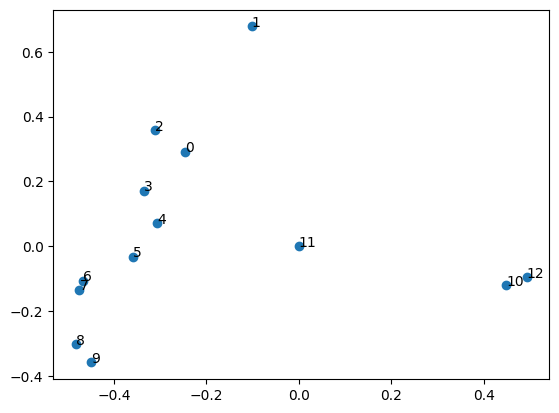

In [51]:
emb = model.embed.Emb.weight.data.detach().cpu()

svdEMB = torch.svd(emb)

a, b = 0, 1

x = svdEMB[0][:, a] * svdEMB[1][a]
y = svdEMB[0][:, b] * svdEMB[1][b]

plt.scatter(x, y)

i = 0
for x, y in zip(x, y):
    plt.annotate(f'{i}', (x, y))
    i += 1

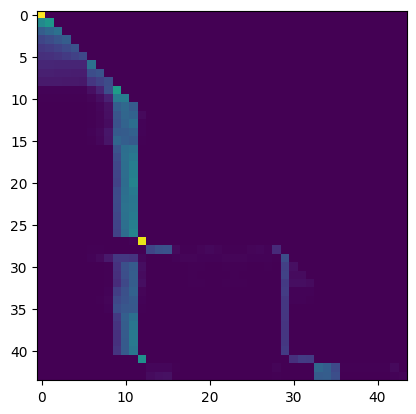

In [71]:
att = model.decoder.layers[5].attn.attn[0, 1].detach().cpu()

plt.imshow(att)